<a href="https://colab.research.google.com/github/ThiagoPurdue/AAE490_tools/blob/main/3Dprinted_airplane_misssion_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Mission Performance Analysis: 3D-Printed Glider

This notebook provides a comprehensive performance sweep for a 3D-printed UAV.

* **Mission Profile:** Hand launch  8s Powered Climb  Unpowered Glide.
* **Goal:** Maximize total flight endurance by optimizing velocity and verifying stability.
* **Constraints:** High wing loading (common in 3D prints) and a short 8-second motor burst.

---

## Cell : Parameters & Constants

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Environment
rho = 1.225  # Air density at sea level (kg/m^3)
g = 9.81     # Gravity (m/s^2)

# Aircraft Physical Properties
mass = 0.850  # Total mass (kg)
weight = mass * g
S = 0.25      # Wing area (m^2)
AR = 8.5      # Aspect Ratio
e = 0.8       # Oswald efficiency factor
c = 0.15      # Mean Aerodynamic Chord (m)
b = S/c       # span


# Aerodynamic Coefficients (Conservative for 3D printed surfaces)
Cd0 = 0.040   # Zero-lift drag coefficient
k = 1 / (np.pi * AR * e) # Induced drag factor

# Propulsion & Power
T_avg = 5.0        # Average thrust (N)
t_motor = 8.0      # Motor run time (s)
prop_eff = 0.70    # Combined motor/ESC/prop efficiency

---

### Drag Polar & Power Curves
To maximize endurance, we look for the minimum power required ($P_{req}$), which corresponds to the minimum sink rate. The power required for level flight is:
$$P_{req} = D \cdot V$$
Where total drag $D = \frac{1}{2} \rho V^2 S (C_{D,0} + k C_L^2)$.

---



Minimum Power Required: 5.14 W at 7.00 m/s


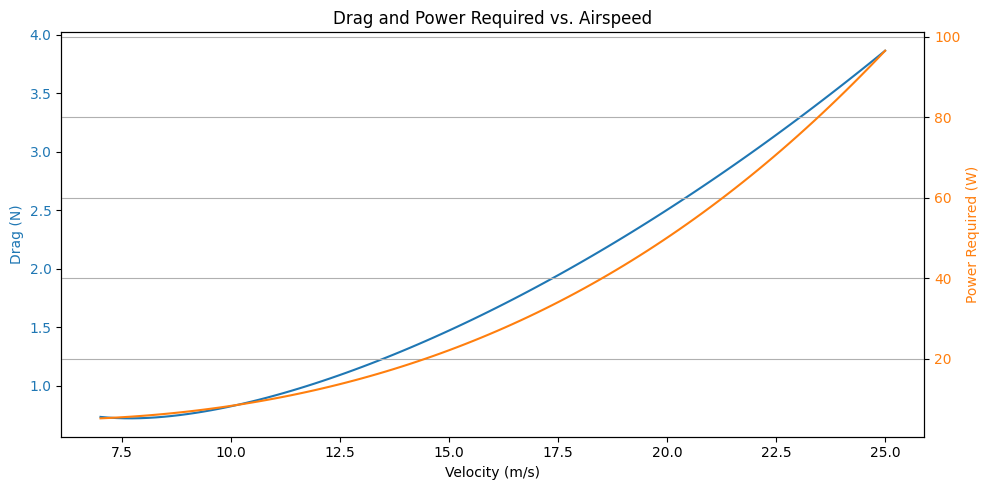

In [30]:
# Velocity range for analysis (m/s)
v_range = np.linspace(7, 25, 100)

# Lift required for level flight (L = W)
Cl_req = weight / (0.5 * rho * v_range**2 * S)

# Drag Calculation
Cd_total = Cd0 + k * Cl_req**2
Drag = 0.5 * rho * v_range**2 * S * Cd_total

# Power Calculation
Power_req = Drag * v_range

# Key Performance Indices
idx_min_power = np.argmin(Power_req)
v_min_power = v_range[idx_min_power]
p_min_level = Power_req[idx_min_power]

print(f"Minimum Power Required: {p_min_level:.2f} W at {v_min_power:.2f} m/s")

# Plotting Drag and Power
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Velocity (m/s)')
ax1.set_ylabel('Drag (N)', color='tab:blue')
ax1.plot(v_range, Drag, color='tab:blue', label='Total Drag')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Power Required (W)', color='tab:orange')
ax2.plot(v_range, Power_req, color='tab:orange', label='Power Required')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Drag and Power Required vs. Airspeed')
plt.grid(True)
fig.tight_layout()
plt.show()

---

### Mission Phase Analysis
#### 1. Powered Climb Phase
During the 8s burst, the rate of climb ($RoC$) is determined by excess power.
#### 2. Unpowered Glide Phase
Total endurance is the sum of the climb time and the time taken to descend from the reached altitude.

---


In [31]:
# Assume climb at a steady airspeed (close to v_min_power for efficiency)
V_climb = v_min_power + 2.0
Cl_climb = weight / (0.5 * rho * V_climb**2 * S)
Cd_climb = Cd0 + k * Cl_climb**2
D_climb = 0.5 * rho * V_climb**2 * S * Cd_climb

# Power during climb
P_mech_climb = T_avg * V_climb
P_elec_climb = P_mech_climb / prop_eff

# Altitude Gained
RoC = (P_mech_climb - (D_climb * V_climb)) / weight
h_climb = RoC * t_motor

# Glide Phase
sink_rate = Power_req / weight
v_s_min = np.min(sink_rate)
t_glide = h_climb / v_s_min

print(f"--- MISSION RESULTS ---")
print(f"Sink_rate: {v_s_min:.2f} m/s")
print(f"t_glide: {t_glide:.2f} s")
print(f"Electrical Power Draw: {P_elec_climb:.2f} W")
print(f"Altitude at Motor Cutoff: {h_climb:.2f} m")
print(f"Glide Endurance: {t_glide:.2f} s")
print(f"Total Mission Time: {t_motor + t_glide:.2f} s")

--- MISSION RESULTS ---
Sink_rate: 0.62 m/s
t_glide: 59.44 s
Electrical Power Draw: 64.29 W
Altitude at Motor Cutoff: 36.62 m
Glide Endurance: 59.44 s
Total Mission Time: 67.44 s


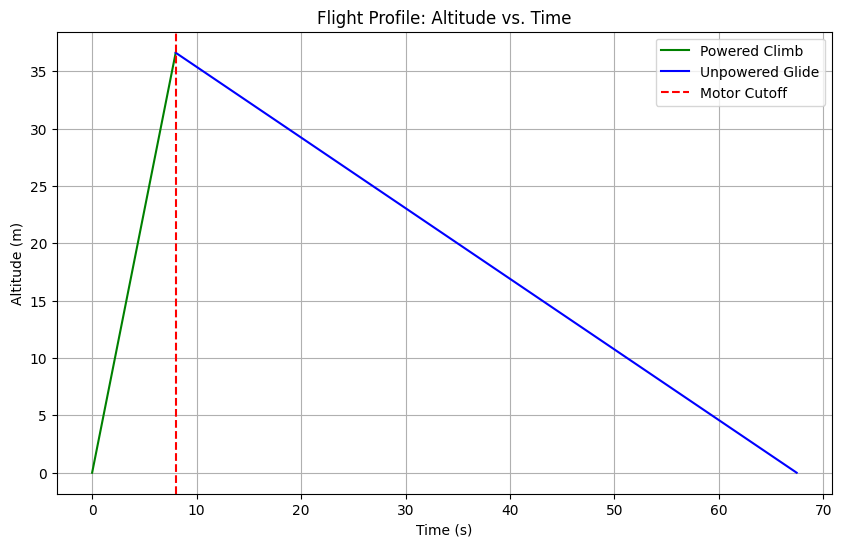

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Climb phase
time_climb = np.linspace(0, t_motor, 100)
altitude_climb = RoC * time_climb

# Glide phase
time_glide = np.linspace(t_motor, t_motor + t_glide, 100)
altitude_glide = h_climb - v_s_min * (time_glide - t_motor)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_climb, altitude_climb, label='Powered Climb', color='green')
plt.plot(time_glide, altitude_glide, label='Unpowered Glide', color='blue')
plt.axvline(x=t_motor, color='red', linestyle='--', label='Motor Cutoff')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.title('Flight Profile: Altitude vs. Time')
plt.grid(True)
plt.legend()
plt.show()

In [33]:
import numpy as np

# 1. Calculate the horizontal component of the velocity during the powered climb
V_h_climb = np.sqrt(V_climb**2 - RoC**2)

# 2. Calculate the total horizontal distance covered during the powered climb
x_climb = V_h_climb * t_motor

# 3. Calculate the horizontal component of the velocity during the unpowered glide
V_h_glide = np.sqrt(v_min_power**2 - v_s_min**2)

# 4. Calculate the total horizontal distance covered during the unpowered glide
x_glide = V_h_glide * t_glide

# 5. Print both x_climb and x_glide
print(f"Horizontal distance during powered climb (x_climb): {x_climb:.2f} m")
print(f"Horizontal distance during unpowered glide (x_glide): {x_glide:.2f} m")

Horizontal distance during powered climb (x_climb): 61.99 m
Horizontal distance during unpowered glide (x_glide): 414.49 m


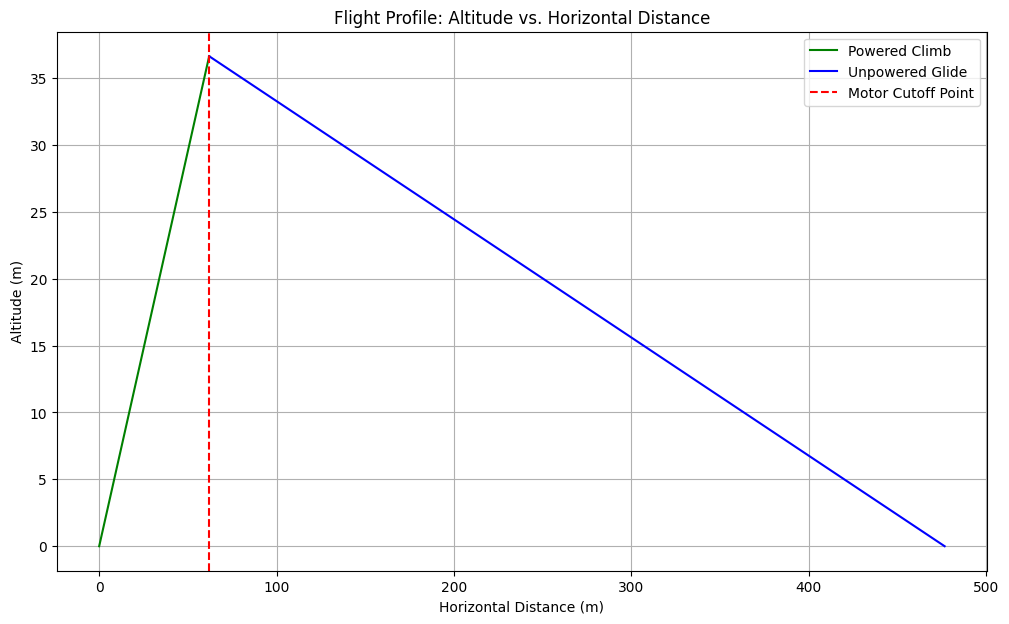

In [34]:
import matplotlib.pyplot as plt

# Create cumulative horizontal distance for climb phase
x_climb_cumulative = np.linspace(0, x_climb, 100)

# Create cumulative horizontal distance for glide phase
x_glide_cumulative = np.linspace(x_climb, x_climb + x_glide, 100)

# Plotting Altitude vs. Horizontal Distance
plt.figure(figsize=(12, 7))
plt.plot(x_climb_cumulative, altitude_climb, label='Powered Climb', color='green')
plt.plot(x_glide_cumulative, altitude_glide, label='Unpowered Glide', color='blue')
plt.axvline(x=x_climb, color='red', linestyle='--', label='Motor Cutoff Point')
plt.xlabel('Horizontal Distance (m)')
plt.ylabel('Altitude (m)')
plt.title('Flight Profile: Altitude vs. Horizontal Distance')
plt.grid(True)
plt.legend()
plt.show()